In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import utils
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier
from RandomForest import RandomForestClassifierImpl

Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [24]:
max = 7
precision = .1

def create_grid():
  return np.mgrid[-max:max:precision, -max:max:precision]

In [25]:
# Распределение 1
_dist1_comp_1 = multivariate_normal([-2,2], [[7, 0], [-1, 2]])
_dist1_comp_2 = multivariate_normal([2,1], [[4, 1], [1, 2]])

def prob_1(pos):
  return _dist1_comp_1.pdf(pos) + _dist1_comp_2.pdf(pos)

In [26]:
# Распределение 2
_dist2_comp_1 = multivariate_normal([3,0], [[2, 1], [1, 2]])
_dist2_comp_2 = multivariate_normal([0,-2], [[4, 1], [1, 2]])
_dist2_comp_3 = multivariate_normal([-1,-1], [[4, 1], [1, 2]])

def prob_2(pos):
  return _dist2_comp_1.pdf(pos) + _dist2_comp_2.pdf(pos) + _dist2_comp_3.pdf(pos)

In [27]:
x, y = create_grid()
pos = np.dstack((x, y))

In [28]:
maxProb1 = np.max(prob_1(pos))
maxProb2 = np.max(prob_2(pos))

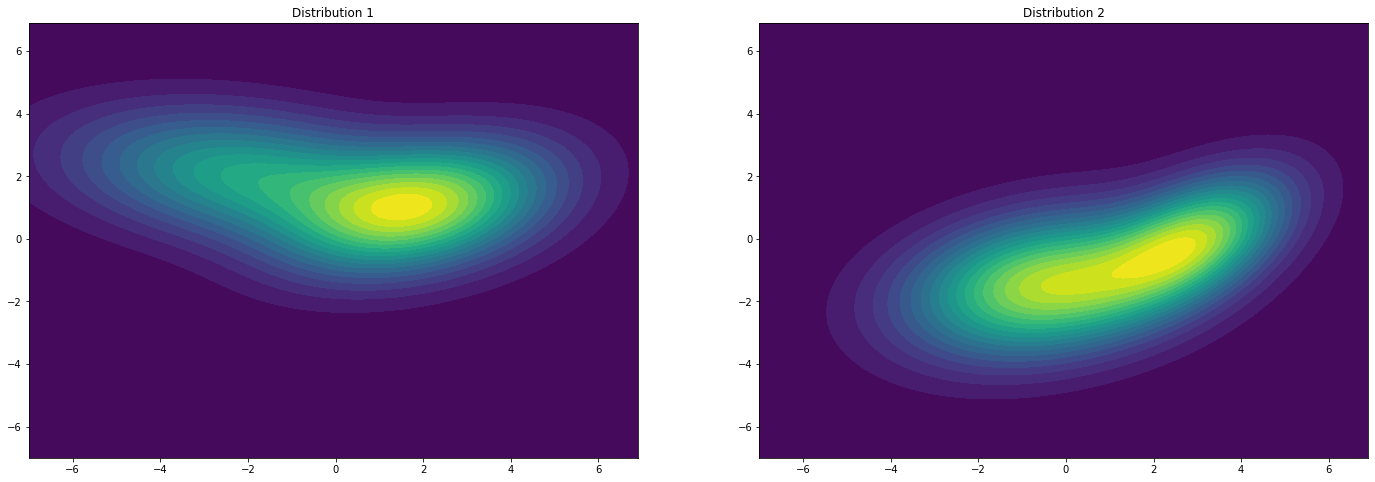

In [29]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Distribution 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)

ax2 = fig.add_subplot(122)
ax2.set_title('Distribution 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)

plt.show()

Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.

In [30]:
def generate_samples(prob, max_prob, size, target):
  samples = []
  while len(samples) != size:
    randCoords = np.random.uniform(-max, max, 2)
    randProb = np.random.uniform(0.0, 1.0, 1)[0]
    sample_prob = prob([randCoords[0], randCoords[1]])
    if (sample_prob / max_prob > randProb):
      samples.append([target, randCoords[0], randCoords[1]])
  return np.array(samples)

def generate_dataset(size, verbose = False):
  size1 = round(np.random.normal(size / 2, 7, 1)[0])
  if size1 <= 0 or size1 > size:
    size1 = round(size / 2)

  samples1 = generate_samples(prob_1, maxProb1, size1, 1)
  samples2 = generate_samples(prob_2, maxProb2, size - size1, 2)

  if verbose:
    print(f"Created samples: {size}")
    print(f"Samples ratio: {size1}/{size - size1}")

  dataset = np.concatenate([samples1, samples2])
  return utils.shuffle(dataset)

In [31]:
dataset = generate_dataset(100, verbose=True)

Created samples: 100
Samples ratio: 53/47


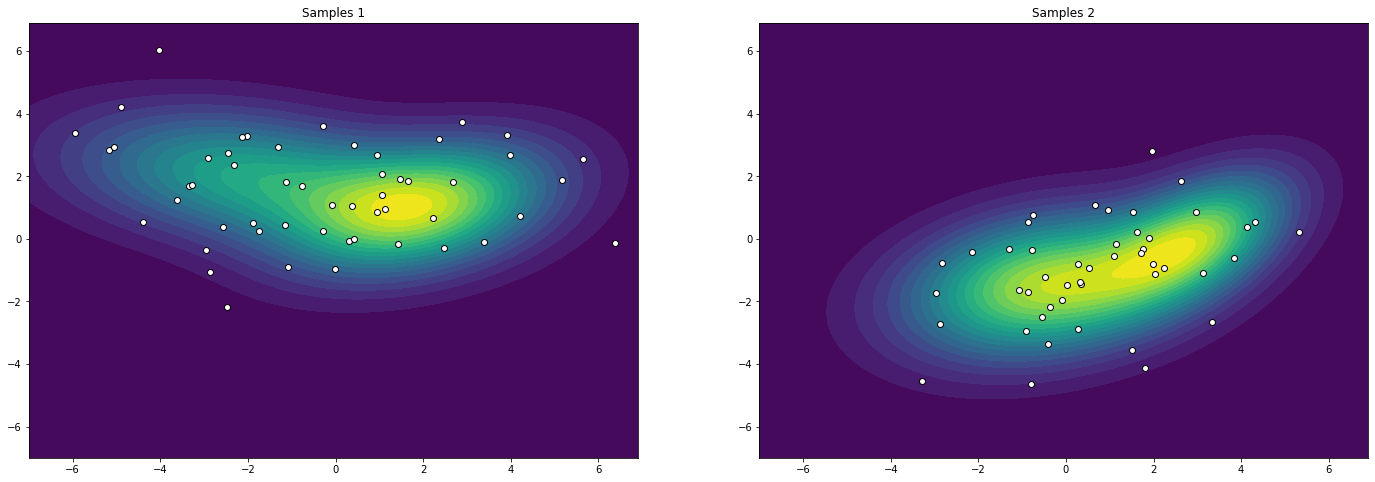

In [32]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Samples 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)
ax.scatter(dataset[dataset[:, 0] == 1, 1], dataset[dataset[:, 0] == 1, 2], c='white', edgecolors='black')

ax2 = fig.add_subplot(122)
ax2.set_title('Samples 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)
ax2.scatter(dataset[dataset[:, 0] == 2, 1], dataset[dataset[:, 0] == 2, 2], c='white', edgecolors='black')

plt.show()

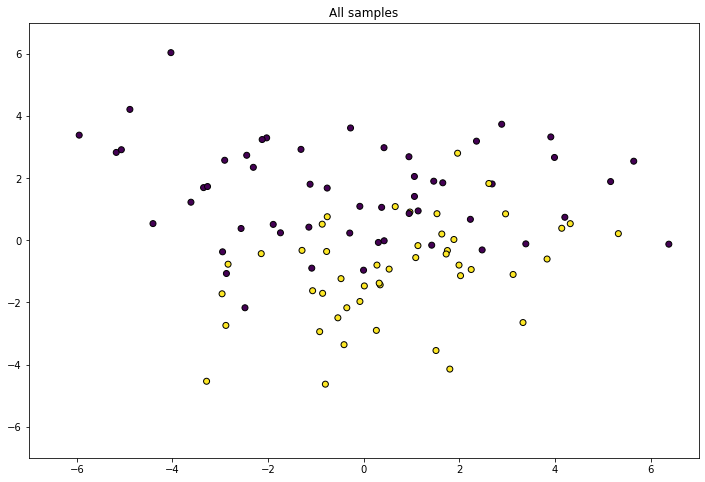

In [33]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_title('All samples')
ax.set_xlim(-max, max)
ax.set_ylim(-max, max)
ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');

In [34]:
def draw_predictions_on_decision_plane(clf, ax, dataset, decision_grid):
    ax.set_xlim(-max, max)
    ax.set_ylim(-max, max)
    cs = ax.contourf(x, y, decision_grid , levels=1)
    ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');
    predictions = clf.predict(dataset[:, 1:])
    ax.scatter(dataset[dataset[:, 0] != predictions, 1], 
            dataset[dataset[:, 0] != predictions, 2], c='red', marker='x')


def decision_plane_test(clf, train_dataset, test_dataset):
    clf.fit(train_dataset[:, 1:], train_dataset[:, 0])
    decision_grid = clf.predict(pos.reshape(pos.shape[0]**2, 2))
    decision_grid = decision_grid.reshape(pos.shape[0],pos.shape[1])

    fig = plt.figure(figsize=(24, 8))

    train_sub_plot = fig.add_subplot(121)
    train_sub_plot.set_title(f'Prediction result on the decision plane | Train score: {clf.score(train_dataset[:, 1:], train_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, train_sub_plot, train_dataset, decision_grid)
    
    test_sub_plot = fig.add_subplot(122)
    test_sub_plot.set_title(f'Prediction result on the decision plane | Test score: {clf.score(test_dataset[:, 1:], test_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, test_sub_plot, test_dataset, decision_grid)

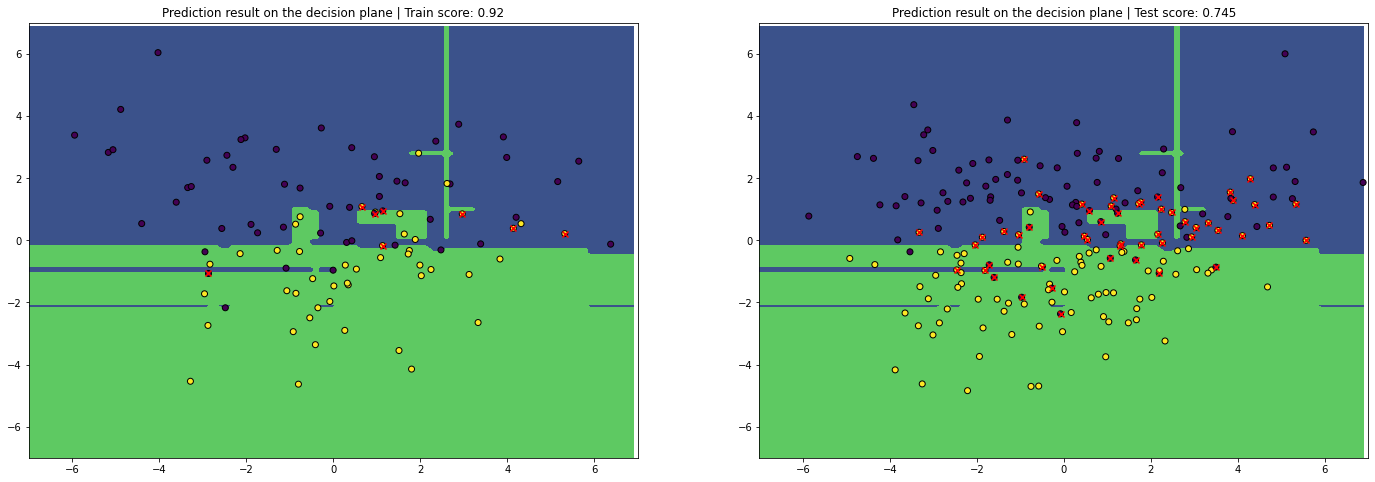

In [35]:
test_dataset = generate_dataset(200)
clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

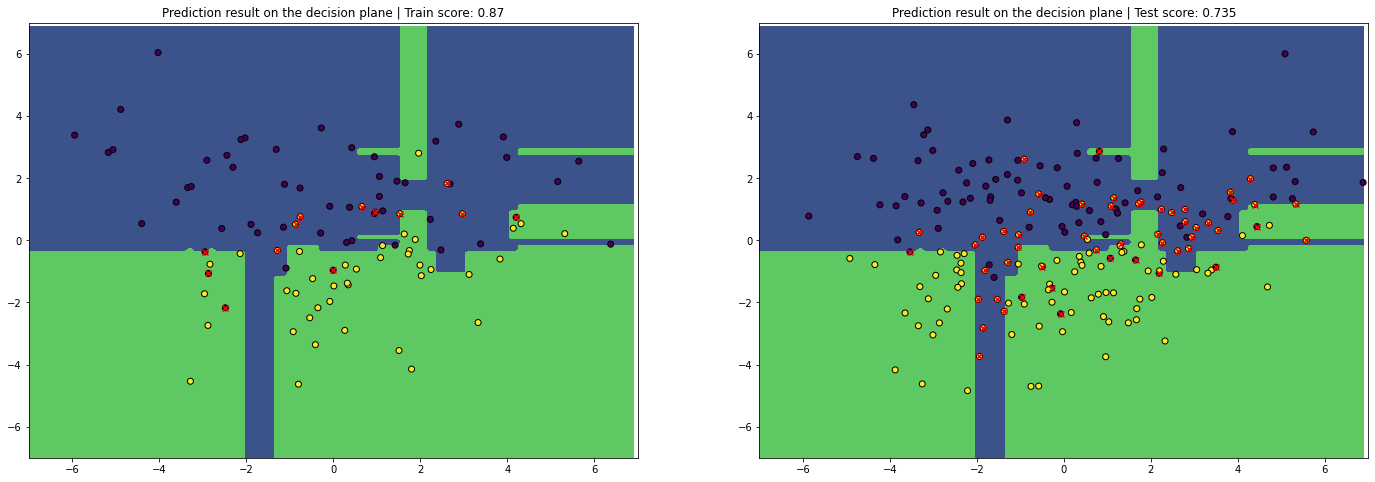

In [36]:
clf = RandomForestClassifierImpl(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

In [37]:
def RandomForestClassifierGetter(n_estimators, max_depth):
    def GetModel():
        return  RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    return GetModel

In [38]:
def score_test(clf_getter, repeats):
  results = []
  for i in range(repeats):
    clf = clf_getter()
    print(f'Test {i}/{repeats}')
    result = []

    train_dataset = generate_dataset(100)
    X = train_dataset[:, 1:]
    y = train_dataset[:, 0]

    clf.fit(X, y)
    result.append(1 - clf.score(X, y))
    
    clf = clf_getter()
    scores_cv = []
    kFolds = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kFolds.split(y):
      X_train = np.take(X, train_index, axis=0)
      X_test = np.take(X, test_index, axis=0)
      y_train = np.take(y, train_index)
      y_test = np.take(y, test_index)
      clf.fit(X_train, y_train)
      scores_cv.append(1 - clf.score(X_test, y_test))
    result.append(np.mean(scores_cv))

    test_dataset = generate_dataset(100)
    X = test_dataset[:, 1:]
    y = test_dataset[:, 0]
    result.append(1 - clf.score(X, y))

    results.append(result)
  
  df = pd.DataFrame(results)
  df.columns = ['Эмпирический риск','Скользящий экзамен','Контрольная выборка']
  return df

In [39]:
results = score_test(RandomForestClassifierGetter(10, 5), 15)

Test 0/15
Test 1/15
Test 2/15
Test 3/15
Test 4/15
Test 5/15
Test 6/15
Test 7/15
Test 8/15
Test 9/15
Test 10/15
Test 11/15
Test 12/15
Test 13/15
Test 14/15


    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0                0.10                0.32                 0.27
1                0.05                0.19                 0.22
2                0.08                0.25                 0.25
3                0.07                0.24                 0.26
4                0.05                0.16                 0.26
5                0.12                0.38                 0.29
6                0.08                0.24                 0.25
7                0.11                0.22                 0.26
8                0.08                0.22                 0.21
9                0.07                0.16                 0.20
10               0.03                0.15                 0.34
11               0.11                0.27                 0.33
12               0.14                0.34                 0.29
13               0.06                0.29                 0.24
14               0.03                0.22              

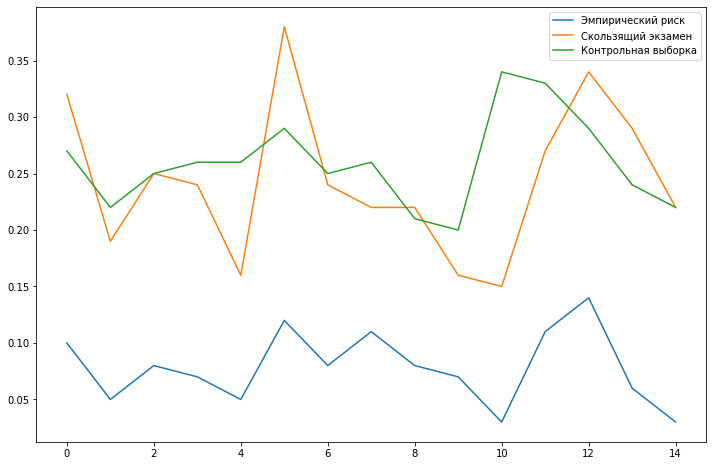

In [40]:
print(results);
results.plot(figsize=(12,8));

Средние отклонения
    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0            0.021333            0.076667             0.010667
1            0.028667            0.053333             0.039333
2            0.001333            0.006667             0.009333
3            0.008667            0.003333             0.000667
4            0.028667            0.083333             0.000667
5            0.041333            0.136667             0.030667
6            0.001333            0.003333             0.009333
7            0.031333            0.023333             0.000667
8            0.001333            0.023333             0.049333
9            0.008667            0.083333             0.059333
10           0.048667            0.093333             0.080667
11           0.031333            0.026667             0.070667
12           0.061333            0.096667             0.030667
13           0.018667            0.046667             0.019333
14           0.048667            0.0

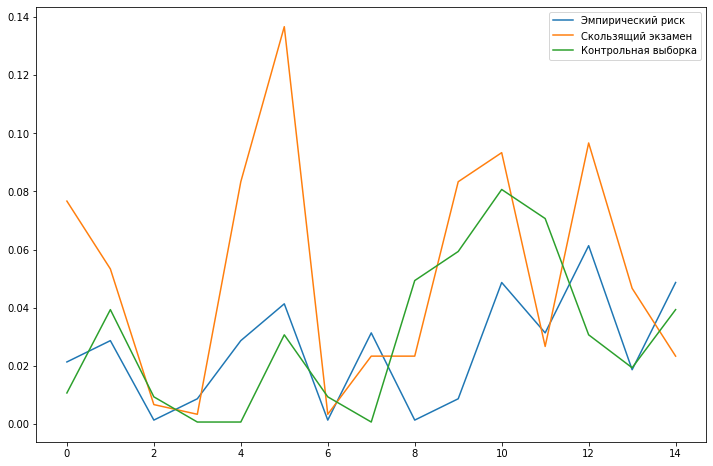

In [41]:
results_lin_error = results.copy()
for i in range(len(results_lin_error.columns)):
    mean = results_lin_error.iloc[:,i].mean()
    results_lin_error.iloc[:,i] = abs(results_lin_error.iloc[:,i] - mean)
print("Средние отклонения")
print(results_lin_error)
results_lin_error.plot(figsize=(12,8));

Cтандартные  отклонения
    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0            0.000455            0.005878         1.137778e-04
1            0.000822            0.002844         1.547111e-03
2            0.000002            0.000044         8.711111e-05
3            0.000075            0.000011         4.444444e-07
4            0.000822            0.006944         4.444444e-07
5            0.001708            0.018678         9.404444e-04
6            0.000002            0.000011         8.711111e-05
7            0.000982            0.000544         4.444444e-07
8            0.000002            0.000544         2.433778e-03
9            0.000075            0.006944         3.520444e-03
10           0.002368            0.008711         6.507111e-03
11           0.000982            0.000711         4.993778e-03
12           0.003762            0.009344         9.404444e-04
13           0.000348            0.002178         3.737778e-04
14           0.002368          

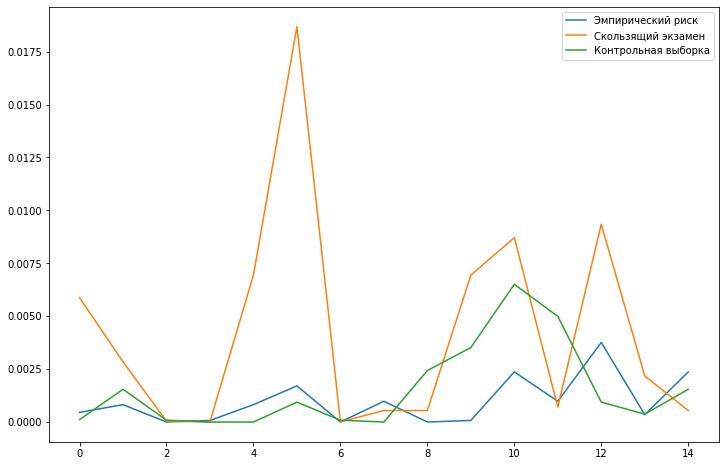

In [42]:
results_lin_error = results.copy()
for i in range(len(results_lin_error.columns)):
    mean = results_lin_error.iloc[:,i].mean()
    results_lin_error.iloc[:,i] = (results_lin_error.iloc[:,i] - mean)**2
print("Cтандартные  отклонения")
print(results_lin_error)
results_lin_error.plot(figsize=(12,8));

In [43]:
results = score_test(RandomForestClassifierGetter(30, 20), 15)

Test 0/15
Test 1/15
Test 2/15
Test 3/15
Test 4/15
Test 5/15
Test 6/15
Test 7/15
Test 8/15
Test 9/15
Test 10/15
Test 11/15
Test 12/15
Test 13/15
Test 14/15


    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0                0.00                0.21                 0.17
1                0.01                0.15                 0.22
2                0.01                0.20                 0.20
3                0.00                0.26                 0.29
4                0.00                0.23                 0.35
5                0.00                0.24                 0.30
6                0.00                0.26                 0.25
7                0.00                0.33                 0.29
8                0.01                0.31                 0.25
9                0.00                0.21                 0.30
10               0.00                0.25                 0.25
11               0.00                0.24                 0.27
12               0.00                0.25                 0.21
13               0.00                0.26                 0.26
14               0.00                0.20              

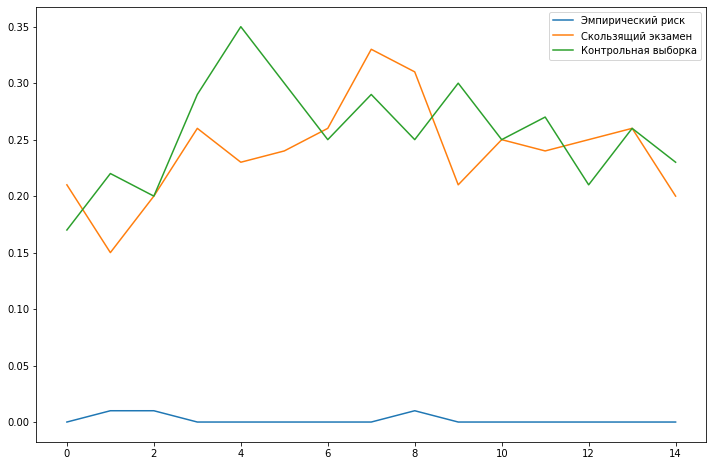

In [44]:
print(results);
results.plot(figsize=(12,8));

Средние отклонения
    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0               0.002        3.000000e-02                0.086
1               0.008        9.000000e-02                0.036
2               0.008        4.000000e-02                0.056
3               0.002        2.000000e-02                0.034
4               0.002        1.000000e-02                0.094
5               0.002        5.551115e-17                0.044
6               0.002        2.000000e-02                0.006
7               0.002        9.000000e-02                0.034
8               0.008        7.000000e-02                0.006
9               0.002        3.000000e-02                0.044
10              0.002        1.000000e-02                0.006
11              0.002        0.000000e+00                0.014
12              0.002        1.000000e-02                0.046
13              0.002        2.000000e-02                0.004
14              0.002        4.00000

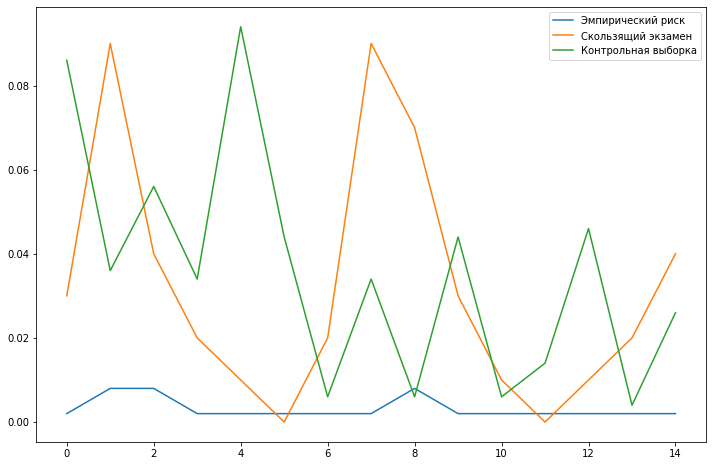

In [45]:
results_lin_error = results.copy()
for i in range(len(results_lin_error.columns)):
    mean = results_lin_error.iloc[:,i].mean()
    results_lin_error.iloc[:,i] = abs(results_lin_error.iloc[:,i] - mean)
print("Средние отклонения")
print(results_lin_error)
results_lin_error.plot(figsize=(12,8));

Cтандартные  отклонения
    Эмпирический риск  Скользящий экзамен  Контрольная выборка
0            0.000004        9.000000e-04             0.007396
1            0.000064        8.100000e-03             0.001296
2            0.000064        1.600000e-03             0.003136
3            0.000004        4.000000e-04             0.001156
4            0.000004        1.000000e-04             0.008836
5            0.000004        3.081488e-33             0.001936
6            0.000004        4.000000e-04             0.000036
7            0.000004        8.100000e-03             0.001156
8            0.000064        4.900000e-03             0.000036
9            0.000004        9.000000e-04             0.001936
10           0.000004        1.000000e-04             0.000036
11           0.000004        0.000000e+00             0.000196
12           0.000004        1.000000e-04             0.002116
13           0.000004        4.000000e-04             0.000016
14           0.000004        1.

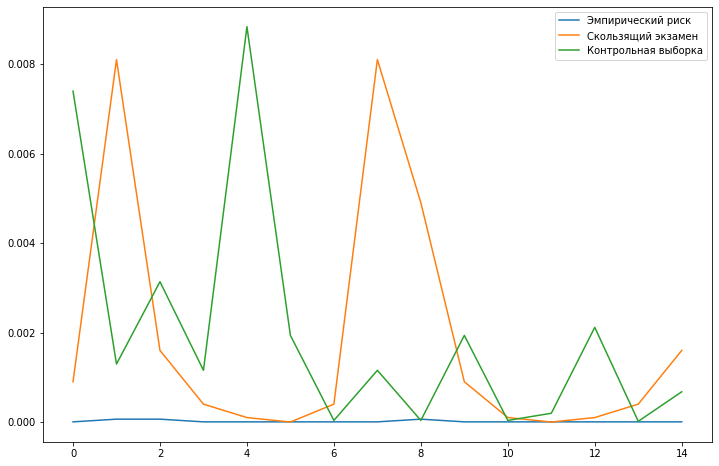

In [46]:
results_lin_error = results.copy()
for i in range(len(results_lin_error.columns)):
    mean = results_lin_error.iloc[:,i].mean()
    results_lin_error.iloc[:,i] = (results_lin_error.iloc[:,i] - mean)**2
print("Cтандартные  отклонения")
print(results_lin_error)
results_lin_error.plot(figsize=(12,8));